In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import os
import cpi

from tabulate import tabulate

DIR = "../data/"
CONT_COL = "CONT" 

In [241]:
df = pd.read_csv('../data/distribution/merged_filtered.csv')
df = df[df[CONT_COL] > 0]

# ---- we should consider which territories to keep in -------------------
# remove territories
to_remove = ['AS', 'FO', 'FM', 'GU', 'MH', 'MP', 'PR', 'VI']
df = df[(df['STATE'].isna() == False)]
for st in to_remove:
    df = df[df['STATE'] != st]
# ------------------------------------------------------------------------

count    4.284110e+05
mean     1.943297e+06
std      2.592170e+07
min      1.000000e+00
25%      3.061150e+04
50%      1.312000e+05
75%      6.395605e+05
max      9.265120e+09
Name: CONT, dtype: float64


<AxesSubplot:ylabel='Density'>

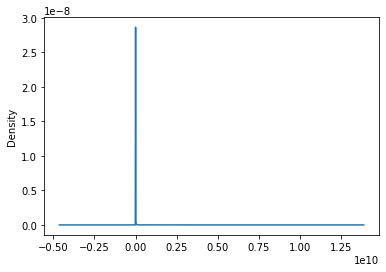

In [242]:
print(df[CONT_COL].describe())
df[CONT_COL].plot(kind='kde')

In [243]:
# remove outliers
q1 = df[CONT_COL].quantile(0.25)
q3 = df[CONT_COL].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
df = df[(df[CONT_COL] < high)]

count    3.656050e+05
mean     2.374916e+05
std      3.338713e+05
min      1.000000e+00
25%      2.365300e+04
50%      8.760100e+04
75%      3.034630e+05
max      1.552829e+06
Name: CONT, dtype: float64


<AxesSubplot:ylabel='Density'>

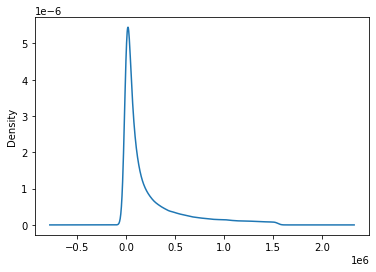

In [244]:
print(df[CONT_COL].describe())
df[CONT_COL].plot(kind='kde')

Adjusting for inflation... would love for someone to check my work here to make sure I'm doing this right.

In [267]:
# adjusting for inflation in terms of 2019
path = os.path.join(DIR, 'distribution', 'cpi_all.csv')
cpi = pd.read_csv(path)

# 990 forms filed may annually
cpi = cpi[['Year', 'May']]
years = cpi['Year'].tolist()

infl_adj = df[df['FISYR'] == max(df['FISYR'].tolist())].copy()
pct_rate = 0
for i in range(len(years) - 2, -1, -1):
    pct_rate += cpi.loc[i, 'May'] / 100
    temp = df[df['FISYR'] == years[i]].copy()
    temp[CONT_COL] = temp[CONT_COL].apply(lambda x: x * (pct_rate + 1))
    infl_adj = pd.concat([infl_adj, temp])

In [268]:
total_conts = df[['FISYR', CONT_COL]].groupby('FISYR').sum().reset_index()
total_conts_adj = infl_adj[['FISYR', CONT_COL]].groupby('FISYR').sum().reset_index()

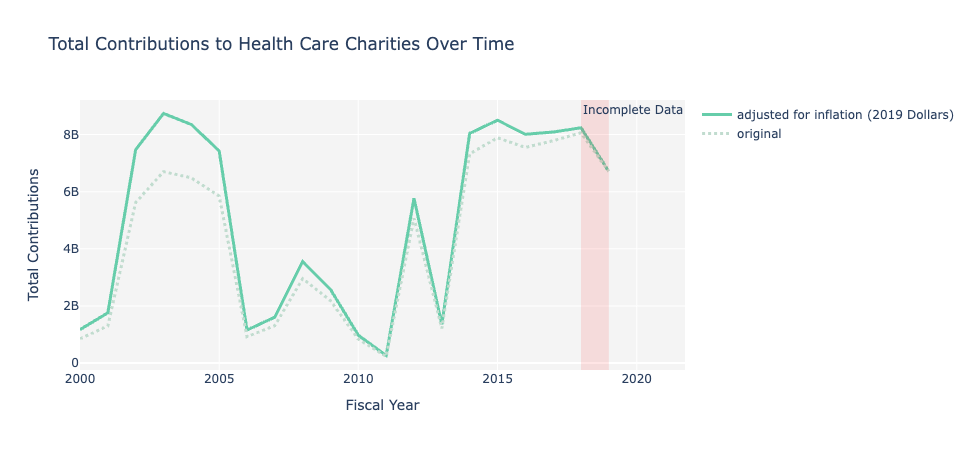

In [269]:
fig = go.Figure()

line1 = go.Scatter(x=total_conts_adj['FISYR'], y=total_conts_adj[CONT_COL], name='adjusted for inflation ('
                   + str(int(max(total_conts['FISYR'].tolist()))) + ' Dollars)', 
                   line = dict(color = ('mediumaquamarine'), width = 3))
line2 = go.Scatter(x=total_conts['FISYR'], y=total_conts[CONT_COL], name='original', 
                   line = dict(color = ('rgba(193, 220, 207, 1)'), width = 3, dash='dot'))

fig.add_trace(line1)
fig.add_trace(line2)
fig.add_vrect(x0=max(total_conts['FISYR'].tolist()) - 1, x1=max(total_conts['FISYR'].tolist()), 
              annotation_text="Incomplete Data", annotation_position="top left",
              fillcolor="red", opacity=0.1, line_width=0)

fig.update_layout(
    title='Total Contributions to Health Care Charities Over Time',
    xaxis_title='Fiscal Year',
    yaxis_title='Total Contributions',
    plot_bgcolor='rgba(200, 200, 200, 0.2)'
) 
fig.show()

was reading the data guide and there was something that mentioned certain parts of the data are not adjusted for inflation --> does this imply the rest of it is? can't find anything explicitly saying it is or isn't